In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import scipy.stats as ss
import seaborn as sns
import random
%matplotlib inline

In [97]:
NOISE_SIGMA = 5
MAX_STEP = 500
POPULATION = 1000
PROB = 0.8
TRAILS = 1000

# Random Models

In [3]:
def ind_white_noises(size, sigma):
    return np.random.normal(0, sigma, size).reshape(POPULATION,1)

## Individual AutoRegressive

In [250]:
def ind_var_simulations(trails):
    simulations = defaultdict(list)
    X = np.array(range(1,POPULATION+1)).reshape(POPULATION,1)
    coff = np.identity(POPULATION) * np.random.rand(POPULATION, POPULATION)
    constant = []
    for i in range(POPULATION):
        constant.append(X[i,0] * (1 - coff[i,i]))
    constant = np.array(constant).reshape(POPULATION, 1)
    
    for i in range(1,trails+1):
        X = np.array(range(1,POPULATION+1)).reshape(POPULATION,1)
        np.random.seed(i)
        for t in range(MAX_STEP):
            errors = ind_white_noises(POPULATION, NOISE_SIGMA)
            X = np.matmul(coff, X) + constant + errors
            simulations[i].append(np.transpose(X)[0])
    
    return simulations
        

## Individual RandomWalk

In [251]:
def ind_rw_simulations(trails):
    simulations = defaultdict(list)
    for i in range(1,trails+1):
        X = np.array(range(1,POPULATION+1)).reshape(POPULATION,1)
        np.random.seed(i)
        for t in range(MAX_STEP):
            errors = ind_white_noises(POPULATION, NOISE_SIGMA)
            X = X + errors
            simulations[i].append(np.transpose(X)[0])
    
    return simulations

# Durability Queries

## Top-K Durability

In [291]:
def topk_durability(simulations, target, topk_boundary, time_step = MAX_STEP):
    durability = {}
    for key in simulations:
        yay = 0
        for t, series in enumerate(simulations[key]):
            rank = ss.rankdata(series)
            if rank[target] <= topk_boundary:
                yay += 1
            if t >= time_step:
                break
        durability[key] = yay / time_step
    #sns.distplot(durability, hist=True, kde=False)
    #print(np.mean(durability))
    return durability

In [127]:
def topk_durability_with_index(simulations, target, topk_boundary, level_obj_index):
    durability = []
    for key in simulations:
        yay = 0
        objs = level_obj_index[key][topk_boundary]
        for idx, obj in enumerate(objs):
            if simulations[key][idx][target] <= simulations[key][idx][obj]:
                yay += 1
        durability.append(yay / MAX_STEP)
    sns.distplot(durability, hist=True, kde=False)
    print(np.mean(durability))
    return durability

In [145]:
def iterative_topk_durability(simulations, target, topk_boundary, progress, \
                              stride, candidates, durability):
    
    for candidate in candidates:
        yay = 0
        t = progress[candidate]
        for series in simulations[candidate][t:t+stride]:
            rank = ss.rankdata(series)
            if rank[target] <= topk_boundary:
                yay += 1
        durability[candidate].append([stride, yay])
        progress[candidate] += stride
    
    cum_durability = {}
    for key in durability:
        cum_durability[key] = sum([item[1] for item in durability[key]]) \
        / sum([item[0] for item in durability[key]])
    
    hist, freq_bin = np.histogram(list(cum_durability.values()), bins=np.arange(0,1,0.1))
    print(hist)
    
    max_index, max_value = max(enumerate(hist), key=lambda e: e[1])
    target_freq_lo = max_index / 10
    target_freq_hi = (max_index+1) / 10
    next_candidate = [obj for obj in cum_durability \
                      if cum_durability[obj] >= target_freq_lo and cum_durability[obj] <= target_freq_hi]
    
    return progress, durability, next_candidate

## First Hitting Time (w.r.t top-k)

In [230]:
def fht_durability(simulations, target, topk_boundary, time_step = MAX_STEP):
    durability = {}
    for key in simulations:
        yay = 0
        for t, series in enumerate(simulations[key]):
            rank = ss.rankdata(series)
            if rank[target] <= topk_boundary:
                yay += 1
            else:
                break
        durability[key] = yay
    #sns.distplot(durability, hist=True, kde=False)
    #print(np.mean(durability))
    #return durability
    return durability

# Index & Ordering

In [7]:
def level_index(simulation):
    relevant_obj_index = defaultdict(lambda:defaultdict(list))
    for key in simulation:
        for series in simulation[key]:
            for obj, rank in enumerate(ss.rankdata(series)):
                relevant_obj_index[key][rank].append(obj)
    
    return relevant_obj_index

In [238]:
def world_ordering(simulations, target_level, method='mean'):
    score = defaultdict(int)
    level_score = []
    for key in simulations:
        value = []
        for series in simulations[key]:
            rank = list(ss.rankdata(series))
            target_index = rank.index(target_level)
            value.append(series[target_index])
        if len(value) == 0:
            continue
        #print(np.mean(value))
        if method == 'mean':
            level_score.append(np.mean(value))
            score[key] = np.mean(value)
        if method == 'max':
            level_score.append(np.max(value))
            score[key] = np.max(value)
    #sns.distplot(all_level_mean_value, hist=True, kde=False)
    return score
    

# Visuals

In [62]:
def level_visual(simulations, index, trail, target, topk_boundary):
    level_value = [simulations[trail][idx][obj] for idx, obj in enumerate(index[trail][topk_boundary])]
    relevant_values = []
    for obj in set(index[trail][topk_boundary]):
        obj_value = [simulations[trail][t][obj] for t in range(MAX_STEP)]
        relevant_values.append(obj_value)
        plt.plot(obj_value, color='b')
    plt.plot(level_value, color='r', linewidth=5)
    target_value = [simulations[trail][t][target] for t in range(MAX_STEP)]
    plt.plot(target_value, color='y', linewidth=5)
    for t in range(MAX_STEP-1):
        print(ss.percentileofscore([values[t] for values in relevant_values], level_value[t]))

In [110]:
def incremental_dur_dist(durability):
    dur_dist = []
    for key in durability:
        yay = 0
        total = 0
        for item in durability[key]:
            yay += item[1]
            total += item[0]
        dur_dist.append(yay / total)
    sns.distplot(dur_dist, hist=True, kde=False)
    plt.xlim(0,1)
    print(np.mean(dur_dist))

# Database MC

In [254]:
fht = fht_durability(raw_simulations, 10, 20)

In [255]:
fht_rw = fht_durability(raw_simulations_rw, 10, 20)

In [292]:
dur_percent = topk_durability(raw_simulations, 10, 20)

In [293]:
dur_percent_rw = topk_durability(raw_simulations_rw, 10, 20)

In [256]:
db_score = world_ordering(raw_simulations, 20)

In [257]:
db_score_rw = world_ordering(raw_simulations_rw, 20)

In [281]:
target_score = {}
for key in raw_simulations:
    values = [series[10] for series in raw_simulations[key]]
    target_score[key] = np.mean(values)
target_score_rw = {}
for key in raw_simulations_rw:
    values = [series[10] for series in raw_simulations_rw[key]]
    target_score_rw[key] = np.mean(values)

In [284]:
for key in raw_simulations:
    plt.scatter(target_score[key], fht[key])

In [294]:
for key in raw_simulations:
    plt.scatter(target_score[key], dur_percent[key])

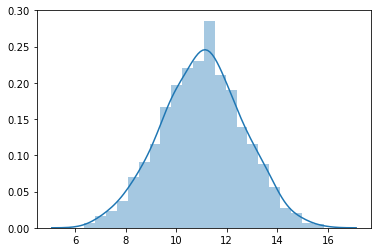

In [282]:
sns.distplot(list(target_score.values()))

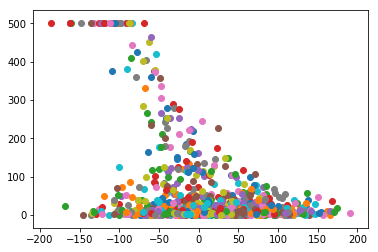

In [285]:
for key in raw_simulations_rw:
    plt.scatter(target_score_rw[key], fht_rw[key])

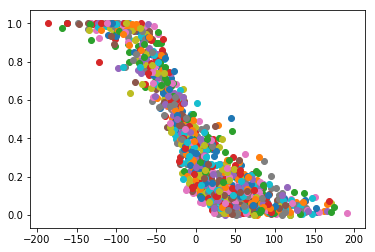

In [295]:
for key in raw_simulations_rw:
    plt.scatter(target_score_rw[key], dur_percent_rw[key])

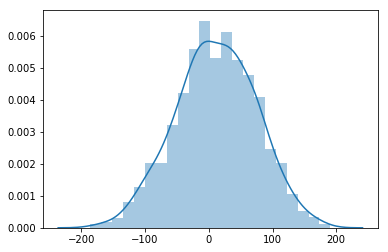

In [283]:
sns.distplot(list(target_score_rw.values()))

# Simulations

## Baseline

In [252]:
raw_simulations = ind_var_simulations(TRAILS)

In [253]:
raw_simulations_rw = ind_rw_simulations(TRAILS)

0.6115700000000001


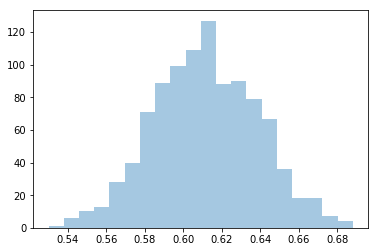

In [128]:
dur810 = topk_durability(raw_simulations, 8, 10)

0.3012139999999999


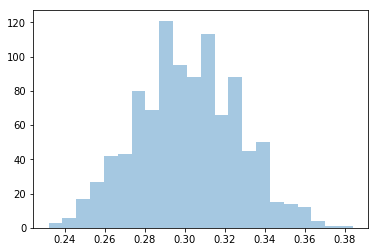

In [129]:
dur1210 = topk_durability(raw_simulations, 12, 10)

0.6689760000000001


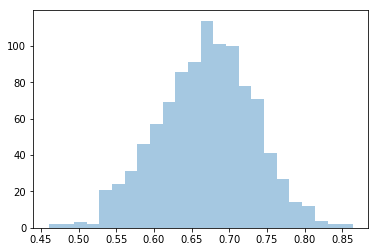

In [130]:
dur510 = topk_durability(raw_simulations, 5, 10)

0.18315399999999998


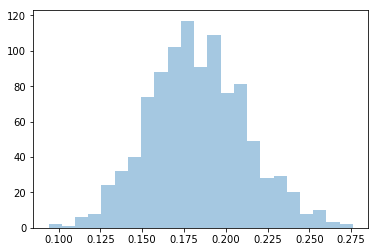

In [131]:
dur1510 = topk_durability(raw_simulations, 15, 10)

## Baseline Partial Simulation (w.r.t top-k-level)

In [12]:
rank_index = level_index(raw_simulations)

0.52254


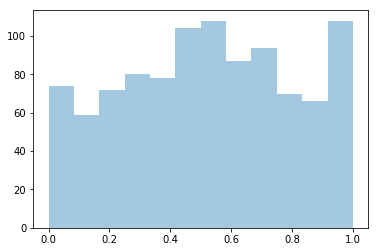

In [13]:
topk_durability_with_index(raw_simulations, 8, 10, rank_index)

0.7250599999999999


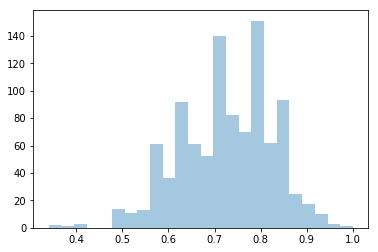

In [14]:
topk_durability_with_index(raw_simulations, 5, 10, rank_index)

0.29252


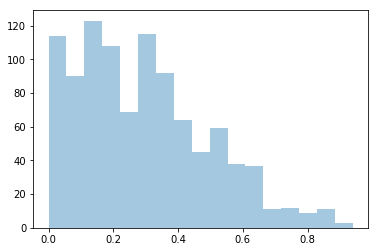

In [15]:
topk_durability_with_index(raw_simulations, 15, 10, rank_index)

In [28]:
print(sorted(set(rank_index[1][1])))
print(sorted(set(rank_index[10][1])))
print(sorted(set(rank_index[100][1])))
print(sorted(set(rank_index[500][1])))

[0, 1, 2, 3, 4, 5, 6]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 35]
[0, 1, 2, 3, 4, 6, 9, 10, 17]
[0, 1, 2, 3, 4, 8, 9]


In [29]:
print(sorted(set(rank_index[1][10])))
print(sorted(set(rank_index[10][10])))
print(sorted(set(rank_index[100][10])))
print(sorted(set(rank_index[500][10])))

[0, 1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 22, 23, 24, 40]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 20, 21, 22, 26, 28]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 20, 21, 22, 23, 28, 29, 35]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 20, 21]


In [32]:
print(sorted(set(rank_index[1][100])))
print(sorted(set(rank_index[10][100])))
print(sorted(set(rank_index[100][100])))
print(sorted(set(rank_index[500][100])))

[64, 82, 87, 90, 92, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 110, 111, 118]
[84, 87, 89, 90, 91, 92, 96, 98, 99, 100, 101, 102, 103, 104, 106, 107, 108, 110, 113]
[73, 81, 90, 91, 92, 93, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 108, 111, 112, 114, 122]
[84, 88, 90, 92, 95, 96, 97, 98, 99, 100, 101, 103, 104, 106, 107, 109, 110, 113, 114]


61.904761904761905
42.857142857142854
4.761904761904762
57.142857142857146
52.38095238095238
61.904761904761905
57.142857142857146
57.142857142857146
57.142857142857146
57.142857142857146
47.61904761904762
57.142857142857146
47.61904761904762
52.38095238095238
42.857142857142854
52.38095238095238
95.23809523809524
57.142857142857146
52.38095238095238
95.23809523809524
80.95238095238095
85.71428571428571
66.66666666666667
61.904761904761905
71.42857142857143
71.42857142857143
57.142857142857146
71.42857142857143
57.142857142857146
80.95238095238095
47.61904761904762
42.857142857142854
47.61904761904762
57.142857142857146
38.095238095238095
47.61904761904762
47.61904761904762
57.142857142857146
57.142857142857146
85.71428571428571
57.142857142857146
47.61904761904762
57.142857142857146
47.61904761904762
71.42857142857143
52.38095238095238
47.61904761904762
71.42857142857143
52.38095238095238
47.61904761904762


IndexError: list index out of range

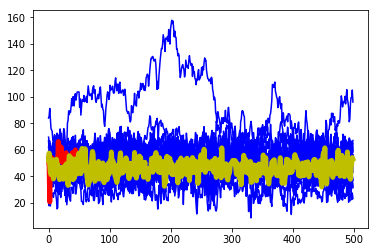

In [199]:
level_visual(raw_simulations, rank_index, 5, 45, 50)

## Incremental Simulation

[  0   0   1   8  74 408 398  99  12]
0.60998


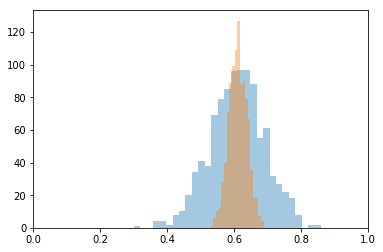

In [146]:
state = defaultdict(int)
candidates = range(1, TRAILS+1)
durability_dist = defaultdict(list)
state, durability_dist, selection = \
iterative_topk_durability(raw_simulations, 8, 10, state, 50, candidates, durability_dist)
incremental_dur_dist(durability_dist)
sns.distplot(dur810,hist=True, kde=False)

[  0   0   1   8  88 262 530  99  12]
0.6201099999999999


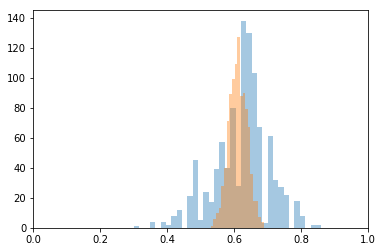

In [147]:
state, durability_dist, selection = \
iterative_topk_durability(raw_simulations, 8, 10, state, 50, selection, durability_dist)
incremental_dur_dist(durability_dist)
sns.distplot(dur810,hist=True, kde=False)

[  0   0   1   8  88 359 417 115  12]
0.61202


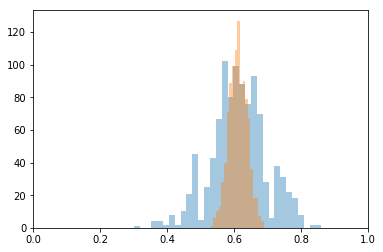

In [148]:
state, durability_dist, selection = \
iterative_topk_durability(raw_simulations, 8, 10, state, 50, selection, durability_dist)
incremental_dur_dist(durability_dist)
sns.distplot(dur810,hist=True, kde=False)

[  0   0   1   8  88 414 351 126  12]
0.6075916666666668


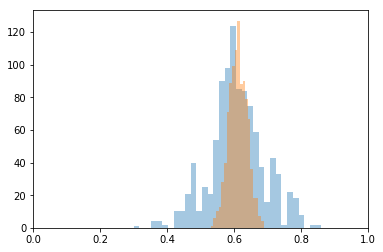

In [149]:
state, durability_dist, selection = \
iterative_topk_durability(raw_simulations, 8, 10, state, 50, selection, durability_dist)
incremental_dur_dist(durability_dist)
sns.distplot(dur810,hist=True, kde=False)

[  0   0   1   8  88 331 434 126  12]
0.6120676666666666


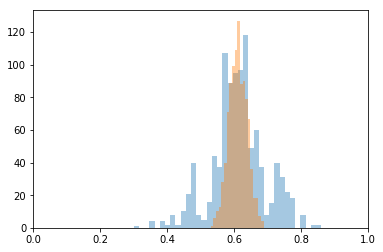

In [150]:
state, durability_dist, selection = \
iterative_topk_durability(raw_simulations, 8, 10, state, 50, selection, durability_dist)
incremental_dur_dist(durability_dist)
sns.distplot(dur810,hist=True, kde=False)

[  0   0   1   8  88 378 385 128  12]
0.6092493333333334


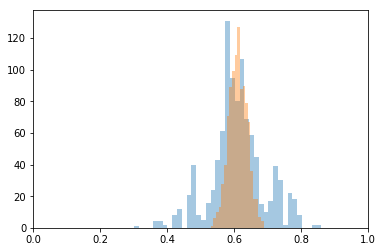

In [151]:
state, durability_dist, selection = \
iterative_topk_durability(raw_simulations, 8, 10, state, 50, selection, durability_dist)
incremental_dur_dist(durability_dist)
sns.distplot(dur810,hist=True, kde=False)

[  0   0   1   8  88 401 358 132  12]
0.6080800952380953


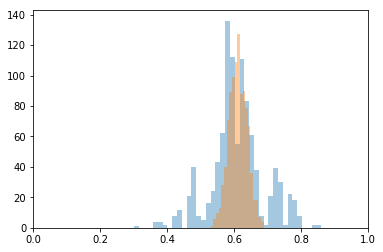

In [152]:
state, durability_dist, selection = \
iterative_topk_durability(raw_simulations, 8, 10, state, 50, selection, durability_dist)
incremental_dur_dist(durability_dist)
sns.distplot(dur810,hist=True, kde=False)

[  0   0   1   8  90 317 440 132  12]
0.6121505238095237


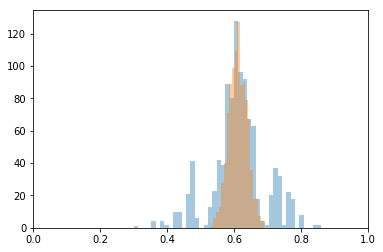

In [153]:
state, durability_dist, selection = \
iterative_topk_durability(raw_simulations, 8, 10, state, 50, selection, durability_dist)
incremental_dur_dist(durability_dist)
sns.distplot(dur810,hist=True, kde=False)

[  0   0   1   8  90 348 409 132  12]
0.6109054047619047


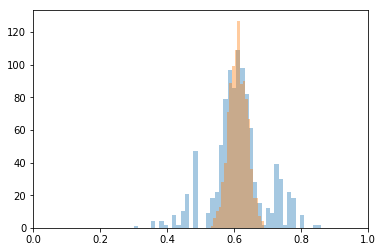

In [155]:
state, durability_dist, selection = \
iterative_topk_durability(raw_simulations, 8, 10, state, 50, selection, durability_dist)
incremental_dur_dist(durability_dist)
sns.distplot(dur810,hist=True, kde=False)

In [154]:
state

defaultdict(int,
            {1: 200,
             2: 250,
             3: 50,
             4: 200,
             5: 50,
             6: 250,
             7: 300,
             8: 50,
             9: 50,
             10: 200,
             11: 50,
             12: 200,
             13: 300,
             14: 250,
             15: 250,
             16: 300,
             17: 200,
             18: 200,
             19: 50,
             20: 250,
             21: 200,
             22: 50,
             23: 100,
             24: 300,
             25: 50,
             26: 200,
             27: 300,
             28: 250,
             29: 250,
             30: 200,
             31: 200,
             32: 50,
             33: 200,
             34: 300,
             35: 50,
             36: 350,
             37: 50,
             38: 50,
             39: 100,
             40: 350,
             41: 300,
             42: 200,
             43: 250,
             44: 250,
             45: 250,
             4

# Frequency Test

[933]


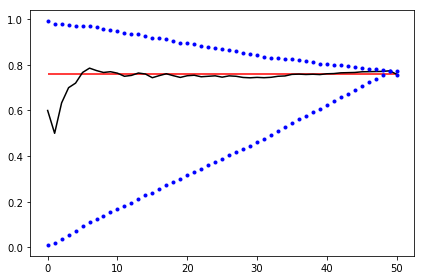

In [198]:
possible_worlds = np.random.choice(TRAILS+1, 1) 
#possible_worlds = [63]
print(possible_worlds)
for idx, w in enumerate(possible_worlds):
    plt.subplot(1,1,idx+1)
    
    freq = []
    hi = []
    lo = []
    t = 0
    yay = 0
    total = 0
    while t <= MAX_STEP:
        for series in raw_simulations[w][t:t+10]:
            rank = ss.rankdata(series)
            if rank[20] <= 25:
                yay += 1
        t += 10
        total += 10
        hi.append((yay + MAX_STEP - t) / MAX_STEP)
        freq.append(yay / total)
        lo.append(yay / MAX_STEP)
        
    plt.plot(freq, color='black')
    plt.hlines(freq[-1],0, 50, color='red')
    plt.plot(hi, '.', color = 'blue')
    plt.plot(lo, '.', color = 'blue')
    #plt.ylim(0.8,1)
    plt.tight_layout()

200


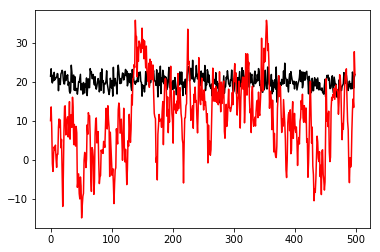

In [280]:
trail_id = 674
print(fht[trail_id])
level_20 = []
for series in raw_simulations[225]:
    rank = list(ss.rankdata(series))
    level_20.append(series[rank.index(20)])
target_10 = [series[10] for series in raw_simulations[225]]
plt.plot(level_20, 'black')
plt.plot(target_10, 'red')

3


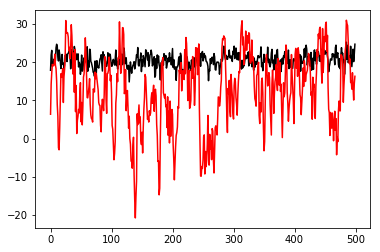

In [273]:
trail_id = 25
print(fht[trail_id])
level_20 = []
for series in raw_simulations[trail_id]:
    rank = list(ss.rankdata(series))
    level_20.append(series[rank.index(20)])
target_10 = [series[10] for series in raw_simulations[trail_id]]
plt.plot(level_20, 'black')
plt.plot(target_10, 'red')

In [278]:
#trail_id = 83
trail_id = 7
# trail_id = 83
# trail_id = 83
# trail_id = 83
print(fht_rw[trail_id])
level_20 = []
for series in raw_simulations_rw[trail_id]:
    rank = list(ss.rankdata(series))
    level_20.append(series[rank.index(20)])
target_10 = [series[10] for series in raw_simulations_rw[trail_id]]
plt.plot(level_20, 'black')
plt.plot(target_10, 'red')

178


20


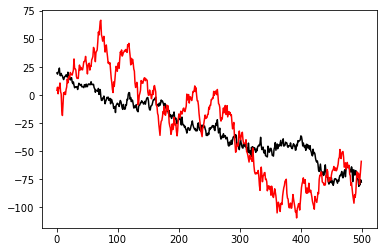

In [276]:
trail_id = 3
print(fht_rw[trail_id])
level_20 = []
for series in raw_simulations_rw[trail_id]:
    rank = list(ss.rankdata(series))
    level_20.append(series[rank.index(20)])
target_10 = [series[10] for series in raw_simulations_rw[trail_id]]
plt.plot(level_20, 'black')
plt.plot(target_10, 'red')

In [279]:
fht

{1: 2,
 2: 32,
 3: 19,
 4: 19,
 5: 17,
 6: 0,
 7: 85,
 8: 42,
 9: 4,
 10: 1,
 11: 2,
 12: 50,
 13: 6,
 14: 2,
 15: 37,
 16: 22,
 17: 0,
 18: 6,
 19: 7,
 20: 1,
 21: 73,
 22: 16,
 23: 17,
 24: 4,
 25: 3,
 26: 95,
 27: 19,
 28: 4,
 29: 38,
 30: 1,
 31: 4,
 32: 30,
 33: 8,
 34: 1,
 35: 22,
 36: 32,
 37: 2,
 38: 6,
 39: 10,
 40: 12,
 41: 42,
 42: 67,
 43: 2,
 44: 16,
 45: 6,
 46: 9,
 47: 25,
 48: 1,
 49: 53,
 50: 1,
 51: 26,
 52: 9,
 53: 77,
 54: 8,
 55: 1,
 56: 39,
 57: 30,
 58: 42,
 59: 9,
 60: 4,
 61: 134,
 62: 12,
 63: 5,
 64: 34,
 65: 1,
 66: 0,
 67: 2,
 68: 11,
 69: 10,
 70: 20,
 71: 36,
 72: 5,
 73: 12,
 74: 39,
 75: 18,
 76: 6,
 77: 16,
 78: 2,
 79: 1,
 80: 89,
 81: 10,
 82: 1,
 83: 115,
 84: 65,
 85: 1,
 86: 2,
 87: 44,
 88: 1,
 89: 40,
 90: 12,
 91: 5,
 92: 1,
 93: 1,
 94: 11,
 95: 0,
 96: 51,
 97: 28,
 98: 7,
 99: 14,
 100: 30,
 101: 31,
 102: 1,
 103: 11,
 104: 9,
 105: 1,
 106: 33,
 107: 10,
 108: 1,
 109: 21,
 110: 91,
 111: 5,
 112: 1,
 113: 13,
 114: 10,
 115: 10,
 116: 4,
